In [ ]:
from IPython.display import clear_output

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader
from torch.optim import SGD
import torch

import matplotlib.pyplot as plt
import matplotlib.patches as patches

#Contents:

We'll make a Faster-RCNN based object detector (bounding box).
The dataset we will train on is PASCAL VOC.
The dataset has 20 different classes of detectable objects.

The classes and the id's we use can be found in the code below.


You need to know:

1. **torch and torchvision(transforms)** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader

In [ ]:
def visualize_boxes(img, bounding_boxes, annotations):
  """
  Helper function to visualize image with all of it's bounding boxes and annotations.
  """

  fig, ax = plt.subplots(1)

  ax.imshow(img)

  for bbox, annotation in zip(bounding_boxes, annotations):

      x_min, y_min, x_max, y_max = bbox
      width = x_max - x_min
      height = y_max - y_min

      rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')

      ax.add_patch(rect)

      plt.text(x_min, y_min - 5, annotation, color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

  plt.axis('off')
  plt.show()


In [ ]:
#  Instead of using default collate function on dataloaders (which is torch.stack), we will define a custom one
#  Since the images have variable number of bounding boxes, stack won't work because stack expects all inputs to be of the same size.
def custom_collate_fn(data):
  return tuple(zip(*data))

### Loading the data

In [ ]:
# Define the dataset path and transform
data_path = "./VOC_data/"
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Load the VOC dataset
train_dataset = VOCDetection(root=data_path, year='2007', image_set='train', download=True, transform=transform)
test_dataset = VOCDetection(root=data_path, year='2007', image_set='test', download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

Using downloaded and verified file: ./VOC_data/VOCtrainval_06-Nov-2007.tar
Extracting ./VOC_data/VOCtrainval_06-Nov-2007.tar to ./VOC_data/
Using downloaded and verified file: ./VOC_data/VOCtest_06-Nov-2007.tar
Extracting ./VOC_data/VOCtest_06-Nov-2007.tar to ./VOC_data/


### Preparing the model
We will use a faster rcnn model with a resnet backbone.

The model is previously trained on COCO dataset and has 91 output classes

We will change and train the box prediction layers (after backbone layers) which will predict 20 classes instead of 91

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 20 # Number of classes for VOC dataset

in_features = model.roi_heads.box_predictor.cls_score.in_features  # input features of bounding box predictor
prev_num_classes = model.roi_heads.box_predictor.cls_score.out_features

# update the bounding box prediction layers with new untrained layers which now predict 20 classes instead of previous.
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

device = "cuda:1" if torch.cuda.is_available() else "cpu"
model.to(device)

print('Old Num Classes: ', prev_num_classes)
print('Using device', device)

/home/salman/anaconda3/envs/pyt/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/salman/anaconda3/envs/pyt/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Old Num Classes:  91
Using device cuda:1


In [ ]:
# No need to train the backbone
# We CAN but it'll take too long and too much computation

model.requires_grad_(False)
model.roi_heads.box_predictor = model.roi_heads.box_predictor.requires_grad_(True)

In [ ]:
# Mappings of label names (found in dataset annotation) to integer IDs (or classes) which we will feed to the model

voc_classes = {
    "aeroplane": 0,
    "bicycle": 1,
    "bird": 2,
    "boat": 3,
    "bottle": 4,
    "bus": 5,
    "car": 6,
    "cat": 7,
    "chair": 8,
    "cow": 9,
    "diningtable": 10,
    "dog": 11,
    "horse": 12,
    "motorbike": 13,
    "person": 14,
    "pottedplant": 15,
    "sheep": 16,
    "sofa": 17,
    "train": 18,
    "tvmonitor": 19,
}

#  Reverse of label to class id mapping. needed because the model predictions will be ids and we need to change it to label to visualize it.
reverse_voc_classes = {v: k for k, v in voc_classes.items()}



In [ ]:
reverse_voc_classes

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

### Training the model

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = SGD(params, lr=1e-5)
optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:

        images = list(image.to(device) for image in images)
        for target in targets:
          boxes = []
          labels = []
          for obj in target['annotation']['object']:
            label = obj['name']
            box = obj['bndbox']
            xmin, ymin, xmax, ymax = [int(box[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
            box = torch.Tensor([xmin, ymin, xmax, ymax]).to(device)
            boxes.append(box)
            labels.append(voc_classes[label])
          target['boxes'] = torch.stack(boxes)
          target['labels'] = torch.Tensor(labels).type(torch.int64).to(device)

        # In training mode, the model will take images and targets and calculate all the losses in internal implementation
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())  # Sum all the different losses.

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {losses.item()}")

Epoch 1/10, Loss: 0.5596181154251099
Epoch 2/10, Loss: 0.772189736366272
Epoch 3/10, Loss: 0.34752047061920166
Epoch 4/10, Loss: 0.6564664840698242
Epoch 5/10, Loss: 0.6329286694526672
Epoch 6/10, Loss: 0.2500825822353363
Epoch 7/10, Loss: 0.24757719039916992
Epoch 8/10, Loss: 0.308823823928833
Epoch 9/10, Loss: 0.19104161858558655
Epoch 10/10, Loss: 0.25837308168411255


In [ ]:
# Visualize the different losses calculated.
print(loss_dict)

{'loss_classifier': tensor(0.0954, device='cuda:1', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1463, device='cuda:1', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0051, device='cuda:1'), 'loss_rpn_box_reg': tensor(0.0116, device='cuda:1')}


### Visualize the results

In [ ]:
model.eval()

clear_output()

In [ ]:
test_img, test_target = test_dataset[100]

test_boxes = []
annotations = []
for obj in test_target['annotation']['object']:
  box = obj['bndbox']
  xmin, ymin, xmax, ymax = [int(box[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
  box = [xmin, ymin, xmax, ymax]
  test_boxes.append(box)
  annotations.append(obj['name'])

with torch.no_grad():
  pred = model([test_img.to(device)])

pred = pred[0]

pred_boxes = pred['boxes']
pred_annotations = pred['labels']
pred_scores = pred['scores']

valid_mask = pred_scores>=0.8

pred_annotations = pred_annotations[valid_mask]
pred_boxes = pred_boxes[valid_mask]

pred_annotations = [reverse_voc_classes[val.item()] for val in pred_annotations]

In [ ]:
def visualize_both_boxes(img, gt_bounding_boxes, gt_annotations,pred_bounding_boxes, pred_annotations):
  """
  Helper function to visualize image with all of it's bounding boxes and annotations.
  """

  fig, ax = plt.subplots(1)

  ax.imshow(img)

  for bbox, annotation in zip(gt_bounding_boxes, gt_annotations):

      x_min, y_min, x_max, y_max = bbox
      width = x_max - x_min
      height = y_max - y_min

      rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='g', facecolor='none')

      ax.add_patch(rect)

      plt.text(x_min, y_min - 5, annotation, color='g', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

  for bbox, annotation in zip(pred_bounding_boxes, pred_annotations):

      x_min, y_min, x_max, y_max = bbox
      width = x_max - x_min
      height = y_max - y_min

      rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')

      ax.add_patch(rect)

      plt.text(x_min, y_min - 5, annotation, color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))



  plt.axis('off')
  plt.show()


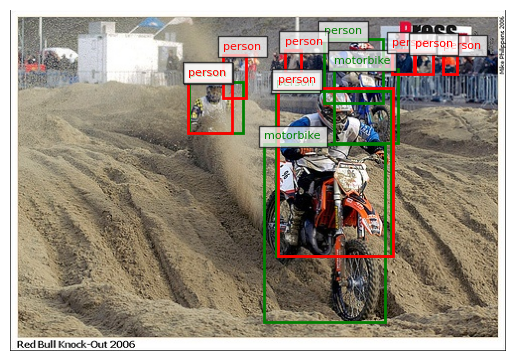

In [ ]:
# Ground truth
# visualize_boxes(F.to_pil_image(test_img), test_boxes, annotations)
visualize_both_boxes(F.to_pil_image(test_img), test_boxes, annotations,pred_boxes.cpu(), pred_annotations)

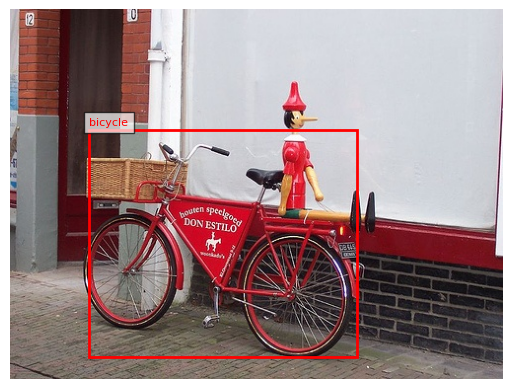

In [ ]:
# Predicted
visualize_boxes(F.to_pil_image(test_img), pred_boxes.cpu(), pred_annotations)

In [ ]:
test_img, test_target = test_dataset[20]

test_boxes = []
annotations = []
for obj in test_target['annotation']['object']:
  box = obj['bndbox']
  xmin, ymin, xmax, ymax = [int(box[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
  box = [xmin, ymin, xmax, ymax]
  test_boxes.append(box)
  annotations.append(obj['name'])

with torch.no_grad():
  pred = model([test_img.to(device)])

pred = pred[0]

pred_boxes = pred['boxes']
pred_annotations = pred['labels']
pred_scores = pred['scores']

valid_mask = pred_scores>=0.8

pred_annotations = pred_annotations[valid_mask]
pred_boxes = pred_boxes[valid_mask]

pred_annotations = [reverse_voc_classes[val.item()] for val in pred_annotations]

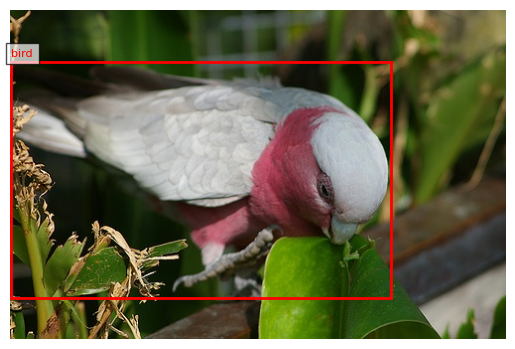

In [ ]:
visualize_boxes(F.to_pil_image(test_img), test_boxes, annotations)

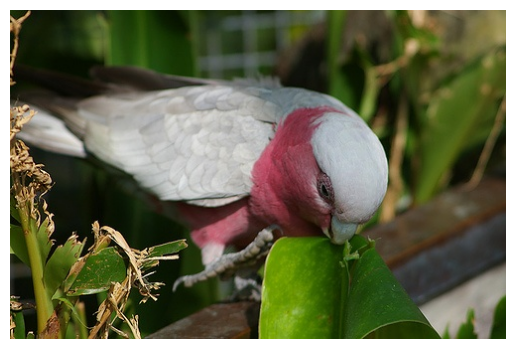

In [ ]:
visualize_boxes(F.to_pil_image(test_img), pred_boxes.cpu(), pred_annotations)